### Import the model from source

In [1]:
import stardist
import csbdeep
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize

In [2]:
model = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.


2022-04-08 16:54:41.338136: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-08 16:54:41.338318: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-08 16:54:41.339485: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


### Show the model in action

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from unified_image_reader import Image

(68536, 64314)
(512, 512, 3)


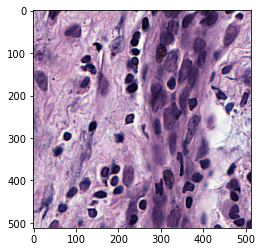

In [4]:
img = Image("/workspaces/dev-container/testing/training-simple/test-wsi/0/84429T_003.tif")
print(img.dims)
region = img.get_region((21300, 12000), region_dims=(512,512))
print(region.shape)
plt.imshow(region)

2022-04-08 16:54:43.246726: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-08 16:54:43.247022: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3791995000 Hz
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


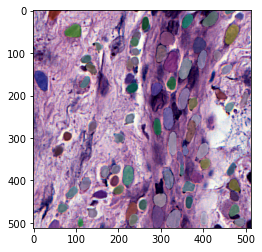

In [5]:
labels, temp = model.predict_instances(normalize(region))

predictions_render = render_label(labels, img=region)
plt.imshow(predictions_render)

In [6]:
print([(k, v.shape) for k,v in temp.items()])
print(temp['coord'][0, :, :])
print(temp['points'][0, :])
print(min(temp['coord'][0,0,:]), min(temp['coord'][0,1,:]))
print(max(temp['coord'][0,0,:]), max(temp['coord'][0,1,:]))
print(temp['prob'][0])

[('coord', (78, 2, 32)), ('points', (78, 2)), ('prob', (78,))]
[[296.       298.13824  300.20203  301.95     303.6616   305.02798
  306.36093  306.94736  307.80594  307.17456  306.7726   305.2892
  303.54196  301.63055  299.79837  297.80273  296.       294.19562
  292.18076  290.18823  288.0737   286.40353  284.96286  284.82672
  284.54596  285.3111   285.79117  286.86588  288.10004  289.67825
  291.54694  293.78506 ]
 [ 91.34393   90.74961   90.14456   88.904816  87.66158   86.03231
   84.29163   82.17756   80.        77.77724   75.53784   73.793144
   72.45803   71.57327   70.82993   70.93702   70.50157   70.928764
   70.779526  71.30206   72.0737    73.58785   75.42827   77.7775
   80.        82.12616   84.228645  86.10323   87.899956  89.46116
   90.750626  91.135284]]
[296  80]
284.54596 70.50157
307.80594 91.34393
0.91593885


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


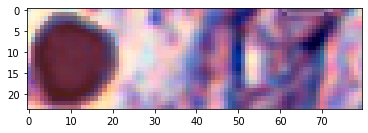

In [7]:
plt.imshow(predictions_render[284:308, 70:150, :])
# coord is y,x --> same with point

### Save model into model manager

In [8]:
import abc
from math import floor, ceil

In [9]:
import cell_level
from cell_level import Segmentation, Instance

In [10]:
class temp(Segmentation.ManagedModel):
    def __init__(self):
        self.model = None
    def get_instances(self, image):
        _, instance_data = self._do_prediction(normalize(image))
        instances = []
        for i, _ in enumerate(instance_data['prob']):
            points_x = instance_data['coord'][i,0,:].astype(int)
            points_y = instance_data['coord'][i,1,:].astype(int)
            instances.append(Instance.Instance(
                points = {'x': points_x, 'y': points_y},
                image = image[
                    floor(min(points_x)) : ceil(max(points_x)),
                    floor(min(points_y)) : ceil(max(points_y)),
                    :
                ],
                score = instance_data['prob'][i]
            ))
        return instances
    def _do_prediction(self, image):
        if self.model is None:
            import stardist
            from stardist import models
            self.model = models.StarDist2D.from_pretrained('2D_versatile_he')
        from csbdeep.utils import normalize
        return model.predict_instances(normalize(image))

In [11]:
class WrappedStarDistModel(Segmentation.ManagedModel):
    def __init__(self):
        self.model = None
    def get_instances(self, image):
        if self.model is None:
            import stardist
            from stardist import models
            self.model = models.StarDist2D.from_pretrained('2D_versatile_he')
        from csbdeep.utils import normalize
        _, instance_data = self.model.predict_instances(normalize(image))
        return self.raw_predictions_to_instances(instance_data, image)
    def raw_predictions_to_instances(self, instance_data, image):
        print(type(instance_data))
        from cell_level import Instance
        instances = []
        for i, _ in enumerate(instance_data['prob']):
            points_x = instance_data['coord'][i,0,:].astype(int)
            points_y = instance_data['coord'][i,1,:].astype(int)
            instances.append(Instance.Instance(
                points = {'x': points_x, 'y': points_y},
                image = image[
                    floor(min(points_x)) : ceil(max(points_x)),
                    floor(min(points_y)) : ceil(max(points_y)),
                    :
                ],
                score = instance_data['prob'][i]
            ))
        return instances

In [12]:
wrapped_model = WrappedStarDistModel()

In [13]:
instances = wrapped_model.get_instances(region)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
<class 'dict'>


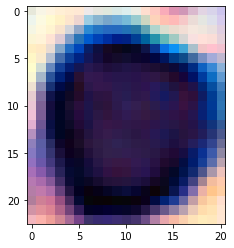

In [14]:
plt.imshow(instances[0].image)

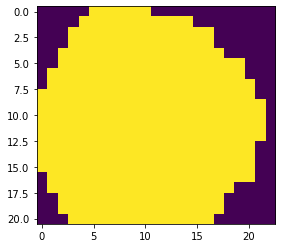

In [15]:
plt.imshow(instances[0].mask)

In [16]:
model_manager = Segmentation.ModelManager()
model_manager.save_model(
    model = WrappedStarDistModel(),
    model_name = "StarDist",
    model_info = {
        "source": "https://pypi.org/project/stardist/"
    },
    overwrite_model = True,
    dependency_modules = [
        stardist,
        stardist.models,
        csbdeep,
        cell_level,
        Instance
    ]
)